# Average Bubble

In [2]:
%matplotlib inline

In [3]:
import os,sys
sys.path.append('./bubbles_codes/')
from bubble_tools import *
from experiment import *
from plotting import *

In [6]:
from matplotlib.colors import LogNorm

Looking at at lambda, T, phi0, m2, sigma: 1.5 0.09 1.3962634015954636 0.01 0.27428630597271203
[10 12 15 17 20 23 25 28 31 33 36 38 41 44 46 49 52 54 57 60]
[4.52612285 4.59830346 4.67048406 4.74266467 4.81484528 4.88702588
 4.95920649 5.0313871  5.10356771 5.17574831 5.24792892 5.32010953
 5.39229013 5.46447074 5.53665135 5.60883195 5.68101256 5.75319317
 5.82537377 5.89755438]
25 1.9301011109426145
final_crit_rad = [38]
final_crit_thresh =  [5.10356771]


/var/folders/y9/3fb45z893_907tsjq09bjhbh0000gn/T/ipykernel_47416/2220162640.py:82: UserWarning: The following kwargs were not used by contour: 'aspect', 'interpolation'
  ax.contour(phits1, rads1, np.abs(np.log(varmat)), levels=6, aspect='auto', interpolation='gaussian', extent=ext, origin='lower', colors='k',linewidths=0.5)


NameError: name 'multiple_formatter' is not defined

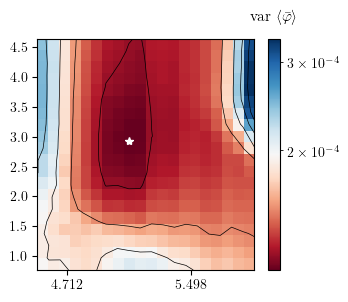

In [5]:
for tmp in [0]:
    phi0, temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
    exp_params = np.asarray([nLat, lamb, phi0, temp])
    labs = labl(lamb, phi0, temp)
    print('Looking at at lambda, T, phi0, m2, sigma:', lamb, temp, phi0, m2(lamb), sigmafld)

    crit_radList    = np.array(np.linspace(10, 60, 20), dtype='int'); print(crit_radList)
    crit_threshList = right_Vmax.x + np.linspace(1, 6, 20) * sigmafld; print(crit_threshList)

    print(25, 25*np.sqrt(m2(lamb))*dx)
    
    win = 200
    considerMaxVel = 0.9 # excludes faster bubbles from average

    plots = False
    get_data = False
    get_plotcomp = True

    if get_data:
        all_data, all_vels = [], []
        for sim in range(minSim, maxSim):      
            path2RESTsim = rest_sim_location(*exp_params, sim)
            if os.path.exists(path2RESTsim):
                sim, bubble, totbeta = np.load(path2RESTsim)
                if np.abs(totbeta) < considerMaxVel:
                    all_vels.append(np.array([sim, totbeta]))
                    all_data.append(np.array([sim, bubble]))
        print('Total bubbles included:', len(all_data))

    if get_plotcomp:
        loadedBubbles = np.zeros((len(crit_radList), len(crit_threshList), 2, 3, 2*win+1, 2*win+1))
        varmat        = np.zeros((len(crit_radList), len(crit_threshList)))

        for cind, cth in enumerate(crit_radList):
            for tind, tsh in enumerate(crit_threshList):
                name = average_file(*exp_params)+'_critrad'+str(cth)+'_crittsh'+str(tsh)+'.npy'
                for xi in range(7, 11, 1):
                    for yi in range(-1000, 1001, 1):
                        namei = name[:-xi] + str(int(name[-xi])+yi) + '.npy'
                        try:
                            loadedBubbles[cind, tind] = np.load(namei)
                        except:
                            #print(tsh, namei)
                            continue
                tp = 1 # 0 for average, 1 for error
                cp = 0 # 0 - field, 1 - momentum, 2 - gradient
                delt1 = 25

                bubble = loadedBubbles[cind, tind, tp, cp]
                nT, nN = np.shape(bubble)
                tl, tr, xl, xr = max(0, win-delt1), min(nT, win+delt1), max(0, win-delt1), min(nN, win+delt1)
                varmat[cind, tind] = np.mean(np.abs(bubble[tl:tr, xl:xr]))

        colmin, rowmin = np.where(varmat == np.min(varmat))
        final_crit_rad = crit_radList[colmin]
        final_crit_thresh = crit_threshList[rowmin]
        if len(final_crit_rad) != 1:
            if len(final_crit_rad) == 0: print('Failed')
            elif len(final_crit_rad) > 1:
                final_crit_rad = final_crit_rad[0]
                final_crit_thresh = final_crit_thresh[0]
        print('final_crit_rad =', final_crit_rad)
        print('final_crit_thresh = ', final_crit_thresh)

        fig, ax = plt.subplots(1,1, figsize = (3.5,3))
        crit_radList_dimless = crit_radList*np.sqrt(m2(lamb))*dx
        ext = [crit_threshList[0], crit_threshList[-1], crit_radList_dimless[0], crit_radList_dimless[-1]]

        im0 = plt.imshow(varmat, interpolation=None, norm=LogNorm(), extent=ext, aspect='auto', origin='lower', cmap='RdBu')
     #   im0 = plt.imshow(varmat, interpolation=None, extent=ext, aspect='auto', origin='lower', cmap='RdBu')
        clb = plt.colorbar(im0)#, format=mticker.FuncFormatter(fmt2))
     #   clb.formatter.set_powerlimits((0, 0))
    #    clb.set_label(r'$\left< \left(\bar{\phi}(\bar{x},\bar{t}) - \left<\bar{\phi}\right> \right)^2 \right>/S$', size=11)
        clb.ax.set_title(r'${\rm var} \, \left< \bar{\varphi} \right> $', size=11, horizontalalignment='center', verticalalignment='bottom')
        clb.ax.yaxis.set_offset_position('right')                         
        plt.plot(final_crit_thresh, final_crit_rad*np.sqrt(m2(lamb))*dx, color='white', marker='*')

        phits = np.linspace(ext[0], ext[1], len(crit_threshList))
        rads  = np.linspace(ext[2], ext[3], len(crit_radList_dimless))
        phits1, rads1 = np.meshgrid(phits, rads)

        ax.contour(phits1, rads1, np.abs(np.log(varmat)), levels=6, aspect='auto', interpolation='gaussian', extent=ext, origin='lower', colors='k',linewidths=0.5)
        ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 4))
        ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))

        ax.tick_params(direction='in', which='both', top=True, right=True)
        labss = r'$T/m = {}$'.format(round(temp/np.sqrt(m2(lamb)),1))
     #   ax.legend(title=labss, loc=2, fancybox=True, frameon=True, framealpha=1, borderpad=0.05)
        ax.text(5.6, 1.1, labss, ha='center', va='center', \
                bbox={'boxstyle':'round','facecolor':'white','alpha':0.85,'edgecolor':'k','pad':0.3}, fontsize=10)
    #    ax.grid(ls=':', color='darkgray', alpha=0.5)
        ax.set_ylabel(r'$m \, R$')    
        ax.set_xlabel(r'$\bar{\phi}$')

        fig.tight_layout()
        plt.savefig('./plots/residual_averaging_T'+str(temp)+'.pdf')
        plt.show()

        if False:
            crit_radList = crit_radList[9::][::2]
            crit_threshList = crit_threshList[3::][::3]
            fig, ax = plt.subplots(len(crit_radList), len(crit_threshList), figsize = (len(crit_threshList)*5, len(crit_radList)*5))
            for cind, cth in enumerate(crit_radList):
                for tind, tsh in enumerate(crit_threshList):
                    tp, cp, delt = 0, 0, 30 # 0 for average, 1 for error

                    average_bubble = loadedBubbles[cind][tind][tp, cp]
                    nT, nN = np.shape(average_bubble)
                    tl, tr, xl, xr = max(0, win-delt), min(nT, win+delt), max(0, win-delt), min(nN, win+delt)
                    ext = [xl, xr, tl, tr]
                    bubble2plot = average_bubble[tl:tr, xl:xr]

                    im0  = ax[cind,tind].imshow(bubble2plot, interpolation=None, extent=ext, origin='lower', cmap='RdBu')
                    clb0 = plt.colorbar(im0, ax = ax[cind,tind])
                    if cth == final_crit_rad and tsh == final_crit_thresh:
                        ax[cind,tind].plot(win, win, color='k', marker='*', ms='10', linestyle=None, \
                                           label='size='+str(cth)+', thresh='+str(format(tsh, '1.2f')))
                    else:
                        ax[cind,tind].plot(win, win, color='k', marker='o', ms='5', linestyle=None, \
                                           label='size='+str(cth)+', thresh='+str(format(tsh, '1.2f')))

                    ax[cind,tind].legend(title=r'$T=$'+str(temp), loc=4, fontsize='small', \
                                         fancybox=True, frameon=True, framealpha=0.75, borderpad=0.3)
            plt.tight_layout()
            plt.show()

In [ ]:
# Little script to produce bubbles of same field kind, but difference velocity brackets
if False:
    velsplit = 0.2
#    velsplit = 0.4

    simvels, veldata = np.array(all_vels)[:,0].astype(int), np.array(all_vels)[:,1]
    a1 = np.argwhere(np.abs(veldata) <= velsplit).flatten()
    a2 = np.argwhere(np.abs(veldata) > velsplit).flatten()
    a3 = np.sort(np.concatenate((a1,a2)))
    a4 = np.array(simvels[a1], dtype='int')
    a5 = np.array(simvels[a2], dtype='int')
    a6 = np.sort(np.concatenate((a4,a5)))
    simindlist = [a1, a2]
    simlist    = [a4, a5]
    print(len(a1), len(a2))

    cp = 0 # 0 - field, 1 - momentum, 2 - gradient

    for stype, (simi, simt) in enumerate(zip(simindlist, simlist)):
        part_data = np.array([all_data[i] for i in simi])
        stacks  = stack_bubbles(part_data, win, phieq, final_crit_thresh, final_crit_rad, plots)
        stacks  = average_stacks(stacks, normal, plots)
        avstack = average_bubble_stacks(stacks)
        np.save(average_file(*exp_params)+'_stype'+str(stype)+'_velsplit'+str(velsplit), avstack)
    print('Done')

    loadedBubbles = np.zeros((len(simlist), 2, 3, 2*win+1, 2*win+1))
    varmat = np.zeros((len(simlist)))
    for stype, (simi, simt) in enumerate(zip(simindlist, simlist)):
        loadedBubbles[stype] = np.load(average_file(*exp_params)+'_stype'+str(stype)+'_velsplit'+str(velsplit)+'.npy')
        tp = 1 # 0 for average, 1 for error
        bubble = loadedBubbles[stype, tp, cp]
        nT, nN = np.shape(bubble)
        delt1 = 30
        tl, tr, xl, xr = max(0, win-delt1), min(nT, win+delt1), max(0, win-delt1), min(nN, win+delt1)
        varmat[stype] = np.mean(np.abs(bubble[tl:tr, xl:xr]))


    fig, ax = plt.subplots(1,1, figsize = (5,4))
    plt.plot(np.arange(len(simlist)), varmat); plt.show()

    fig, ax = plt.subplots(1, 2, figsize = (len(simlist)*5, 5))
    for stype, simi in enumerate(simindlist):
        tp = 0 # 0 for average, 1 for error
        average_bubble = loadedBubbles[stype][tp, cp]
        nT, nN = np.shape(average_bubble)
        delt = 100
        tl, tr, xl, xr = max(0, win-delt), min(nT, win+delt), max(0, win-delt), min(nN, win+delt)
        ext         = [xl, xr, tl, tr]
        bubble2plot = average_bubble[tl:tr, xl:xr]
        
        im0  = ax[stype].imshow(bubble2plot, interpolation='none', extent=ext, origin='lower', cmap='tab20b')
        clb0 = plt.colorbar(im0, ax = ax[stype])
        ax[stype].plot(win, win, color='k', marker='o', ms='5', label='s='+str(stype))
        ax[stype].legend(title=r'$T=$'+str(temp), loc=4, fontsize='small', fancybox=True, frameon=True, framealpha=0.75, borderpad=0.3)
    plt.show()

In [ ]:
if False:
    fig, ax = plt.subplots(2, 1, figsize = (15, 10))
    ax[1].axhline(0., color='darkgray', ls='--')
    ax[0].axhline(phieq, color='darkgray', ls='--')
    ax[0].axhline(2.*np.pi, color='darkgray', ls='--') 
    ax[0].yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
    ax[0].yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))

    for coln in [0, 1]:
        bool = True
        secondary_lines, secondary_labels = [], []
        for stype, simi in enumerate(simindlist):        
            average_bubble = loadedBubbles[stype][0, 0]
            nT, nN = np.shape(average_bubble)
            tcen, xcen  = find_nucleation_center2(average_bubble, phieq, final_crit_thresh, final_crit_rad)
            tl, tr      = max(0, tcen-win), min(nT-1, tcen+win)
            xl, xr      = max(0, xcen-win), min(nN-1, xcen+win)
            ext         = [xl, xr, tl, tr]
            bubble2plot = loadedBubbles[stype][0, coln][tl:tr, xl:xr]

            timesList = np.array(np.sort(np.linspace(tcen-30, tcen+20, 4).tolist()+[tcen]), dtype='int')
            print(tcen, xcen, timesList)

            cols = cycle(['indigo', 'forestgreen', 'orange', 'blue', 'orangered'])
            labs = r'$\phi_0=$'+str('%.2f'%phi0)+r', $\lambda=$'+str(lamb)+r', $T=$'+str(temp)
            lsl = ('-' if stype==1 else ':')
            for tt in timesList:
                col = next(cols)
                data  = bubble2plot[tt]
                xlist = np.linspace(-xcen, nN-xcen, len(data))

                spline  = scp.interpolate.splrep(xlist, data)
                r       = np.linspace(xlist[0], xlist[-1], 2000)
                profile = scp.interpolate.splev(r, spline)

                if tt == tcen:
                    secondary_labels.append(labs)
                    l1, = ax[coln].plot(r, profile, color=col, ls=lsl)
                    secondary_lines.append(l1)

                if bool:
                    ax[coln].plot(r, profile, color=col, ls=lsl, label=(r'$\Delta \bar{t} = $'+str(tt-tcen) if tt!=tcen else r'$\bar{t}_{\rm crit} = $'+str(tt)))
                else:
                    ax[coln].plot(r, profile, color=col, ls=lsl)

            bool = False
        ax[coln].add_artist(ax[coln].legend(secondary_lines, secondary_labels, loc=2))

    ax[0].set_ylabel(r'$\bar{\phi}(r)$')
    ax[1].set_ylabel(r'$\bar{\Pi}(r)$')
    for axx in ax.flatten():
        axx.set_xlabel(r'$m \; r$')
        axx.legend(loc=1)
        axx.grid(False)
    plt.show()


In [7]:
bubbleList, velocitesList, instantonList, tmpList, fldcritList, tcritList, encritList = [], [], [], [], [], [], []
for tmp in [0,1,2,3]:
    phi0, temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
    exp_params = np.asarray([nLat, lamb, phi0, temp])

    bubbleList.append(np.load(average_file(*exp_params)))
    velocitesList.append(np.load(velocities_file(*exp_params)))
    instantonList.append(np.load(supercrit_instanton_file(*exp_params)))
    tmpList.append(tmp)
    fldcritList.append(np.load(critfield_file(*exp_params)))
    tcritList.append(np.load(crittimes_file(*exp_params)))
    encritList.append(np.load(critenerg_file(*exp_params)))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


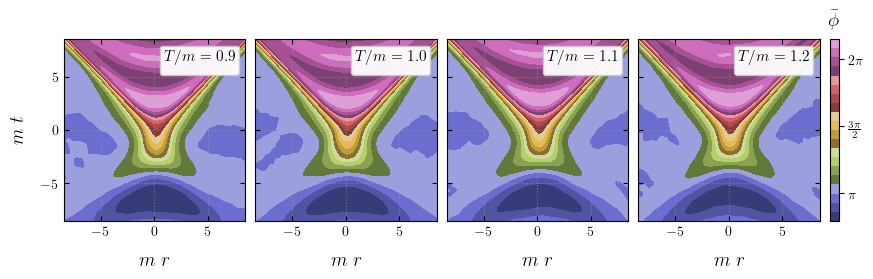

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


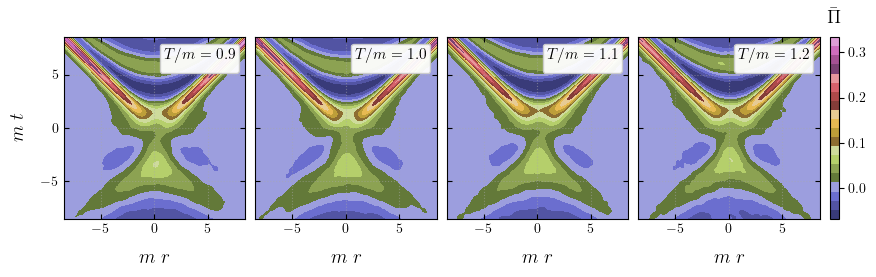

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


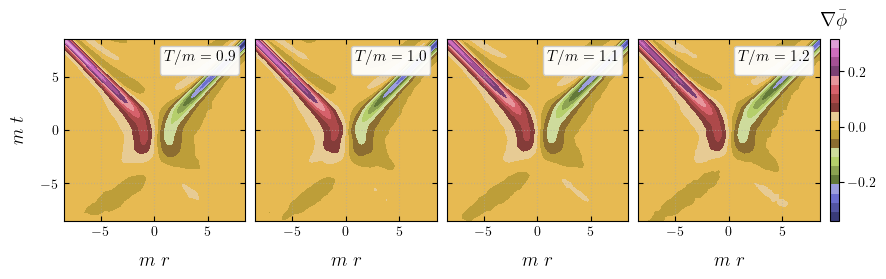

In [35]:
tp = 0# 0 for average, 1 for error

titl = [r'$\bar{\phi}$',  r'$\bar{\Pi}$', r'$\nabla \bar{\phi}$']
for cp in range(3): # 0 - field, 1 - momentum, 2 - gradient

    if cp==0: valmin, valmax = phieq, phieq
    else: valmin, valmax = 0.1, 0.1

    crit_rad = 50
    crit_thresh = right_Vmax.x + 2.*sigmafld
    win = 110
    for ii, average_bubble in enumerate(bubbleList):
        bubble2measure = average_bubble[0,0]
        nT, nN = np.shape(bubble2measure)
        tcen, xcen = find_nucleation_center(bubble2measure, phieq, crit_thresh, crit_rad)
        tcen -= 20
        tl,tr = max(0, tcen-win), min(nT-1, tcen+win)
        xl,xr = max(0, xcen-win), min(nN-1, xcen+win)

        bubble2plot = average_bubble[tp,cp][tl:tr,xl:xr]
        if np.amin(bubble2plot) < valmin: valmin = np.amin(bubble2plot)
        if np.amax(bubble2plot) > valmax: valmax, maxable = np.amax(bubble2plot), ii

    fig = plt.figure(figsize = (10, 3.5))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, len(bubbleList)), share_all=True, axes_pad=0.1, cbar_location="right", cbar_mode="single")
    im = [[]]*len(bubbleList)
    for ii, average_bubble in enumerate(bubbleList):
        tmp = tmpList[ii]
        phi0, temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
        exp_params = np.asarray([nLat, lamb, phi0, temp])
        ext = np.array([xl-xcen,xr-xcen,tl-tcen,tr-tcen])*np.sqrt(m2(lamb))*dx

        bubble2plot = average_bubble[tp,cp][tl:tr,xl:xr]
        im[ii] = grid[ii].imshow(bubble2plot, interpolation='Gaussian', extent=ext, origin='lower', cmap='tab20b')
        im[ii].set_clim(vmin=valmin, vmax=valmax)

        labss = r'$T/m = {}$'.format(round(temp/np.sqrt(m2(lamb)),1))#labl(lamb, phi0, temp)
        grid[ii].legend(title=labss, loc=1, fontsize='small', fancybox=True, frameon=True, framealpha=0.95, borderpad=0.3)
        grid[ii].tick_params(direction='in', which='both', top=True, right=True)
        grid[ii].set(xlabel=r'$m \; r$')
        grid[ii].grid(ls=':', color='darkgray', alpha=0.5)
        grid[0].set(ylabel=r'$m \; t$')

    if cp==0: cbar = grid[ii].cax.colorbar(im[maxable], ticks=mticker.MultipleLocator(np.pi/2), format=mticker.FuncFormatter(multiple_formatter()))
    else: cbar = grid[ii].cax.colorbar(im[maxable])
    grid[ii].cax.toggle_label(True)
    grid[ii].cax.set_title(titl[cp])

    plt.savefig('./plots/average_vacuum_bubble_comparison_'+str(cp)+'.pdf')
    plt.show()


NameError: name 'multiple_formatter' is not defined

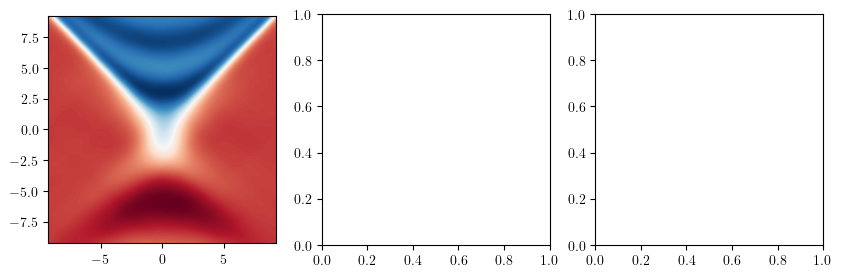

In [8]:
tp = 0# 0 for average, 1 for error

titl = [r'$\bar{\varphi}$',  r'$\bar{\Pi}$', r'$\partial_r\bar{\varphi}$']

for ii, average_bubble in enumerate(bubbleList):
    fig, ax = plt.subplots(1, 3, figsize = (10, 3))
    for cp in range(3): # 0 - field, 1 - momentum, 2 - gradient
        tmp = tmpList[ii]
        phi0, temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
        exp_params = np.asarray([nLat, lamb, phi0, temp])

        crit_rad = 20
        crit_thresh = right_Vmax.x + 2.*sigmafld
        win = 120

        bubble2measure = average_bubble[0,0]
        nT, nN = np.shape(bubble2measure)
        tcen, xcen = find_nucleation_center(bubble2measure, phieq, crit_thresh, crit_rad)
        xcen+=1
        tl,tr = max(0, tcen-win), min(nT-1, tcen+win)
        xl,xr = max(0, xcen-win), min(nN-1, xcen+win)
        ext = np.array([xl-xcen,xr-xcen,tl-tcen,tr-tcen])*np.sqrt(m2(lamb))*dx

        bubble2plot = average_bubble[tp,cp][tl:tr,xl:xr]

        im = ax[cp].imshow(bubble2plot, interpolation=None, extent=ext, origin='lower', cmap='RdBu')
        if cp==0: cbar = plt.colorbar(im, ax=ax[cp], ticks=mticker.MultipleLocator(np.pi/2), format=mticker.FuncFormatter(multiple_formatter()))
        else:
            cbar = plt.colorbar(im, ax=ax[cp])
            lls = cbar.ax.get_ylim()
            a = cbar.ax.get_yticks().tolist()
            a = [round(al,2) for ja,al in enumerate(a) if ja%2==1][::]
            cbar.ax.set_yticks(a)
            #cbar.ax.set_ylim(a[0], a[-1])
            cbar.ax.set_ylim(lls)
            a = [r'${:.1f}$'.format(al) for al in a]
            cbar.ax.set_yticklabels(a)
            
        cbar.ax.set_title(titl[cp])

        nT, nN = np.shape(bubble2plot)
        tt = np.linspace(tl-tcen, tr-tcen, nT)*np.sqrt(m2(lamb))*dx
        xx = np.linspace(xl-xcen, xr-xcen, nN)*np.sqrt(m2(lamb))*dx
        ttt1, xxx1 = np.meshgrid(tt, xx)

        lavs = [8, 6, 8][cp]
        ax[cp].grid(True, color='k', linewidth=0.5, ls=':', alpha=0.2)
        ax[cp].contour(xxx1, ttt1, bubble2plot.T, levels=lavs, aspect='auto', interpolation=None, extent=ext, origin='lower', colors='k',linewidths=0.5)

        ax[cp].tick_params(direction='in', which='both', top=True, right=True)
        ax[cp].set(xlabel=r'$m \, r$')
        ax[0].set(ylabel=r'$m \, t$')
        labss = r'$T/m = {}$'.format(round(temp/np.sqrt(m2(lamb)),1))#labl(lamb, phi0, temp)
#        ax.text(5, -7, labss, ha='center', va='center', \
#                bbox={'boxstyle':'round','facecolor':'white','alpha':0.85,'edgecolor':'k','pad':0.3}, fontsize=10)
        
    plt.tight_layout()
    plt.savefig('./plots/average_bubble'+str(temp)+'.pdf', bbox_inches='tight')
    plt.show()


/var/folders/y9/3fb45z893_907tsjq09bjhbh0000gn/T/ipykernel_1582/97103087.py:37: UserWarning: The following kwargs were not used by contour: 'aspect', 'interpolation'
  ax.contour(xxx1, ttt1, bubble2plot.T, levels=lavs, aspect='auto', interpolation=None, extent=ext, origin='lower', colors='k',linewidths=0.5)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


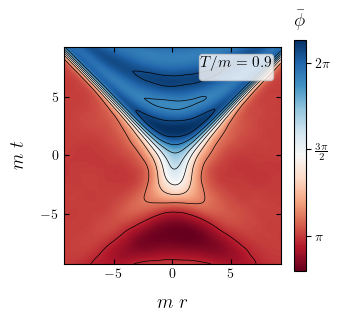

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


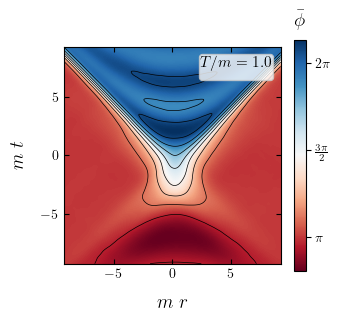

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


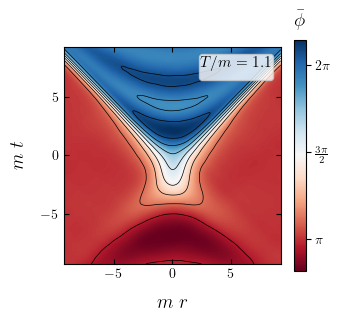

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


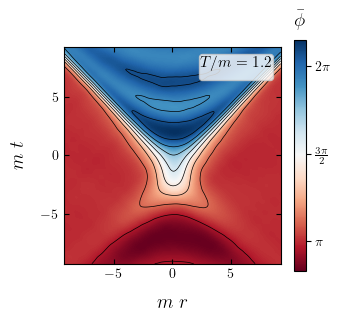

In [11]:
tp = 0# 0 for average, 1 for error

titl = [r'$\bar{\phi}$',  r'$\bar{\Pi}$', r'$\nabla\bar{\phi}$']

for ii, average_bubble in enumerate(bubbleList):
    fig, ax = plt.subplots(1, 1, figsize = (3.5, 3))

    cp = 0
    tmp = tmpList[ii]
    phi0, temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
    exp_params = np.asarray([nLat, lamb, phi0, temp])

    crit_rad = 30
    crit_thresh = right_Vmax.x + 2.*sigmafld
    win = 120

    bubble2measure = average_bubble[0,0]
    nT, nN = np.shape(bubble2measure)
    tcen, xcen = find_nucleation_center(bubble2measure, phieq, crit_thresh, crit_rad)
    tl,tr = max(0, tcen-win), min(nT-1, tcen+win)
    xl,xr = max(0, xcen-win), min(nN-1, xcen+win)
    ext = np.array([xl-xcen,xr-xcen,tl-tcen,tr-tcen])*np.sqrt(m2(lamb))*dx

    bubble2plot = average_bubble[tp,cp][tl:tr,xl:xr]

    im = ax.imshow(bubble2plot, interpolation=None, extent=ext, origin='lower', cmap='RdBu')
    cbar = fig.colorbar(im,ax=ax, ticks=mticker.MultipleLocator(np.pi/2), format=mticker.FuncFormatter(multiple_formatter()))
    cbar.ax.set_title(titl[0])

    nT, nN = np.shape(bubble2plot)
    tt = np.linspace(tl-tcen, tr-tcen, nT)*np.sqrt(m2(lamb))*dx

    xx = np.linspace(xl-xcen, xr-xcen, nN)*np.sqrt(m2(lamb))*dx
    ttt1, xxx1 = np.meshgrid(tt, xx)

    lavs = 8
    ax.contour(xxx1, ttt1, bubble2plot.T, levels=lavs, aspect='auto', interpolation=None, extent=ext, origin='lower', colors='k',linewidths=0.5)

    ax.tick_params(direction='in', which='both', top=True, right=True)
    ax.set(xlabel=r'$m \; r$')
    labss = r'$T/m = {}$'.format(round(temp/np.sqrt(m2(lamb)),1))#labl(lamb, phi0, temp)
    ax.legend(title=labss, loc='best', fancybox=True, frameon=True, framealpha=0.8, borderpad=0.1)
    ax.set(ylabel=r'$m \; t$')
    plt.savefig('./plots/average_bubble'+str(temp)+'.pdf', bbox_inches='tight')
    plt.show()


/var/folders/y9/3fb45z893_907tsjq09bjhbh0000gn/T/ipykernel_1582/2555127721.py:38: UserWarning: The following kwargs were not used by contour: 'aspect', 'interpolation'
  plt.contour(xxx1, ttt1, bubble2plot.T, levels=lavs, aspect='auto', interpolation='none', extent=ext, origin='lower', colors='k',linewidths=0.5)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


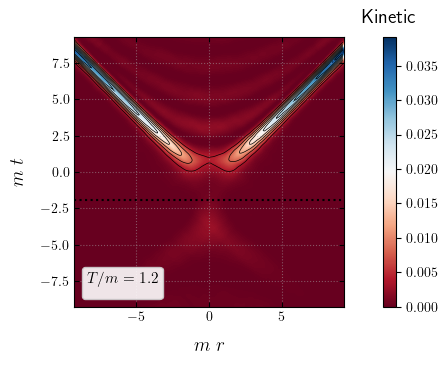

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


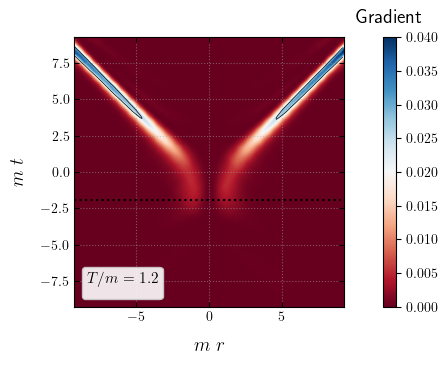

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


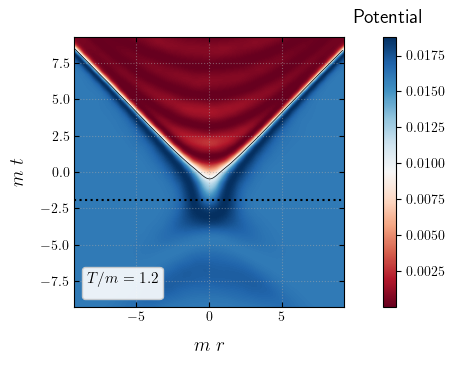

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


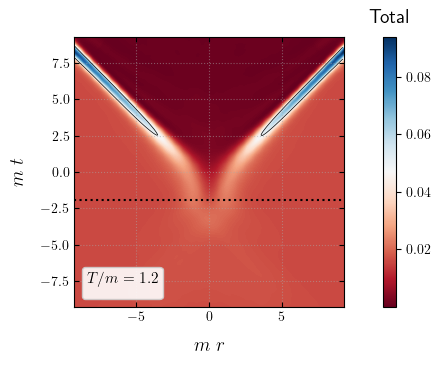

In [12]:
for cp in range(4): # 0 - field, 1 - momentum, 2 - gradient
    tp = 0# 0 for average, 1 for error

    for ii, average_bubble in enumerate(bubbleList):
        tmp = tmpList[ii]
        if tmp!=3: continue

        phi0, temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
        exp_params = np.asarray([nLat, lamb, phi0, temp])

        nT, nN = np.shape(average_bubble[0,0])
        tcen, xcen  = find_nucleation_center2(average_bubble[0,0], phieq, crit_thresh, crit_rad)
        tl, tr      = max(0, tcen-win), min(nT-1, tcen+win)
        xl, xr      = max(0, xcen-win), min(nN-1, xcen+win)

        kinetic, gradient, potential = 0.5*average_bubble[0, 1, tl:tr, xl:xr]**2., 0.5*average_bubble[0, 2, tl:tr, xl:xr]**2., V(average_bubble[0, 0, tl:tr, xl:xr], lamb)
        totEbubble = kinetic + gradient + potential
        picks = [kinetic, gradient, potential, totEbubble]
        bubble2plot = picks[cp]

        bubble2measure = average_bubble[0, 0, tl:tr, xl:xr]
        nT, nN = np.shape(bubble2measure)
        tcen, xcen = find_nucleation_center2(bubble2measure, phieq, crit_thresh, crit_rad)
        ext  = np.asarray([(-xcen), (nN-xcen), (-tcen), (nT-tcen)])*np.sqrt(m2(lamb))*dx

        fig, ax = plt.subplots(1, 1, figsize = (10, 3.5))
        titl = ['Kinetic', 'Gradient', 'Potential', 'Total']
        labss = r'$T/m = {}$'.format(round(temp/np.sqrt(m2(lamb)),1))#labl(lamb, phi0, temp)
        lsl = ('-' if tmp==0 else '--' if tmp==1 else ':')

        im = plt.imshow(bubble2plot, interpolation='antialiased', extent=ext, origin='lower', cmap='RdBu')

        tt = np.arange(-tcen, nT-tcen)*np.sqrt(m2(lamb))*dx
        xx = np.arange(-xcen, nN-xcen)*np.sqrt(m2(lamb))*dx
        ttt1, xxx1 = np.meshgrid(tt, xx)

        lavs = (10 if cp==0 else 1)
        plt.contour(xxx1, ttt1, bubble2plot.T, levels=lavs, aspect='auto', interpolation='none', extent=ext, origin='lower', colors='k',linewidths=0.5)
        cbar = fig.colorbar(im)
        cbar.ax.set_title(titl[cp])
        ax.tick_params(direction='in', which='both', top=True, right=True)
        ax.set(xlabel=r'$m \; r$')

        indmin = int(tcritList[ii])
        ax.axhline((indmin-tl+1-tcen)*np.sqrt(m2(lamb))*dx, ls=':', color='k')
        ax.grid(ls=':', color='darkgray', alpha=0.5)
        ax.set(ylabel=r'$m \; t$')
        plt.legend(title=labss, loc=3, fancybox=True, frameon=True, framealpha=0.9, borderpad=0.3)
        plt.savefig('./plots/average_vacuum_bubble_energies_comparison_'+str(cp)+'.pdf')
        plt.show()


### 
sigmafld0 = np.array([fluct_stdev(lamb, phi0, ti)**2. for ti in tempList[tmpList]])
sigmafld0 = fluct_stdev(lamb, phi0, 0.)**2.

kUV = 2.*np.pi/lenLat*knyq
kIR = 2.*np.pi/lenLat
num = kUV + np.sqrt(kUV**2. + m2(lamb))
denom = kIR + np.sqrt(kIR**2. + m2(lamb))

sigmasqreno = np.log(num/denom)
sigmasqreno = sigmasqreno/np.pi

diffen = sigmasqreno / sigmafld0**2.

print(diffen)